#### Entropy - binomial distribution
We calculate an entropy per each L100 gene set. The entropy is calculated with probabilities based on the binomial distribution for each given L100 gene set, we calculate the binomial probability for each of the target gene sets (number of success = number of overlap genes; number of trials is the number of genes in the given L100 gene set; and probability is size of target gs set over total count of all genes in the target gene sets).

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def getGS(fname):
    df = pd.read_csv(fname, delimiter='_', header=None)
    df['gs'] = df.loc[:,2].str.replace('^\d+\t\t','').str.split('\t')
    df.drop([0,1,2], inplace=True, axis=1)
    return df.copy()

df_assoc = getGS('../out/20.0216 feat/reg_univariate_rf/network/gs.txt') #get the reg univariate-rf results
df_infer = getGS('../out/20.0216 feat/reg_rf_boruta/network/gs.txt') #get the rf-boruta results

# L100 results
df_L100 = pd.read_csv('../19.1013 tight cluster/landmarks_n100_k100.csv')

In [11]:
df_assoc['gs_size'] = df_assoc.apply(lambda x: len(x[0]), axis=1)
df_infer['gs_size'] = df_infer.apply(lambda x: len(x[0]), axis=1)

In [12]:
df_infer.head()

,gs,gs_size
0,"[FASN, ACACA, SCD, HLCS, PRR3, CYB5B, ALG6, KC...",96
1,"[HSD17B12, RNASEH2C, ACTR1B, ACTR1A, VEZT, RTC...",159
2,"[EIF2AK4, UBE2J1, DERL2, UBE2G2, SYVN1, DNAJC3...",76
3,"[CAST, PSTK, EEFSEC, SEPSECS, SEPHS2, GPX4, SE...",64
4,"[AP2M1, ADSL, ACO2, IDH3A, GMPS, TFRC, SDHA, A...",119


In [13]:
df_assoc.head()

,gs,gs_size
0,"[FASN, ACACA, CHP1, GOLGA8EP, GPAT4, GOLGA8CP,...",103
1,"[ACLY, ACSS1, TFRC, MTHFD1, LCA5, AP2M1, PAICS...",117
2,"[SCD, ACSL1, ACSL3, C12orf49, MIR137HG, AC0087...",80
3,"[IL16, SLC37A3, USP22, ATXN7L3, ENY2, SUPT20H,...",82
4,"[SOD2, POP5, AK6, PARN, EXOSC10, NOL6, TAMM41,...",167


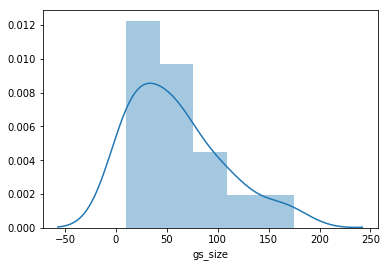

In [14]:
sns.distplot(df_assoc.gs_size)

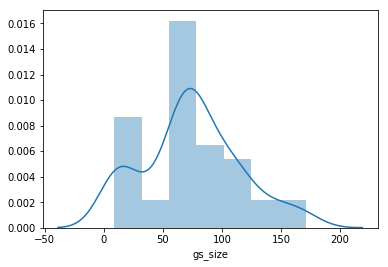

In [15]:
sns.distplot(df_infer.gs_size)

In [16]:
# retrieve the genes L100
df_L100['gs'] = df_L100.genes.apply(lambda x: re.findall('(\w*)\.\.', x))
df_L100['gs'] = df_L100.apply(lambda x: re.findall('(\w*)\s', x['landmark'])+x['gs'], axis=1)
df_L100['gs_size'] = df_L100.apply(lambda x: len(x['gs']), axis=1)
df_L100.head()

,cluster,genes,size,landmark,gs,gs_size
0,1,"ABHD8..79575.,ACP5..54.,ACTL9..284382.,ADAMTS1...",224,TMEM167A (153339),"[TMEM167A, ABHD8, ACP5, ACTL9, ADAMTS10, AKAP8...",225
1,2,"AADAT..51166.,ABAT..18.,ACTL6B..51412.,ADHFE1....",226,CDC40 (51362),"[CDC40, AADAT, ABAT, ACTL6B, ADHFE1, AEBP2, AF...",227
2,3,"AASS..10157.,ADI1..55256.,ADO..84890.,AES..166...",261,PBRM1 (55193),"[PBRM1, AASS, ADI1, ADO, AES, AGXT, AGXT2, AIM...",262
3,4,"ACTR5..79913.,ADRM1..11047.,AICDA..57379.,ARID...",182,PDS5A (23244),"[PDS5A, ACTR5, ADRM1, AICDA, ARID1B, ARID3C, A...",183
4,5,"ABT1..29777.,ACD..65057.,ACTR8..93973.,AFF1..4...",173,SMARCE1 (6605),"[SMARCE1, ABT1, ACD, ACTR8, AFF1, AFF4, AIP, A...",174


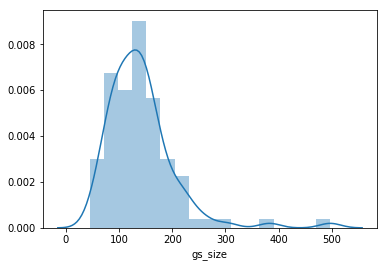

In [17]:
sns.distplot(df_L100.gs_size)

#### calculate binomial probability, and entropy

In [26]:
from scipy.stats import binom

def calcOverlap(df_source, df_target):
    score = 1
    gs_target = df_target['gs']
    gs_target_sizes = df_target['gs_size']
    gs_source = df_source['gs']

    overlap_n = []
    overlap_prob = []
    for gs in gs_target:
        gs_op_n = len(set(gs).intersection(set(gs_source))) # number of genes overlap for given target gs
        overlap_n.append(gs_op_n)
        gs_op_prob = binom.pmf(gs_op_n, n=len(gs_source),p=len(gs)/sum(gs_target_sizes))
        overlap_prob.append(gs_op_prob)

    entropy = -np.sum(overlap_prob* np.log(overlap_prob))
    return entropy

entropy_assoc = df_L100.apply(calcOverlap, df_target=df_assoc, axis=1)
entropy_infer = df_L100.apply(calcOverlap, df_target=df_infer, axis=1)

In [27]:
df_entropy = pd.DataFrame({'assoc': entropy_assoc,
                        'infer': entropy_infer,})

In [28]:
df_entropy.describe()

,assoc,infer
count,100.000000,100.000000
mean,9.809270,7.069215
std,1.809183,2.134816
min,3.828945,2.338946
25%,8.805645,5.651086
50%,9.752168,6.568165
75%,10.987345,8.557816
max,13.529349,12.522639


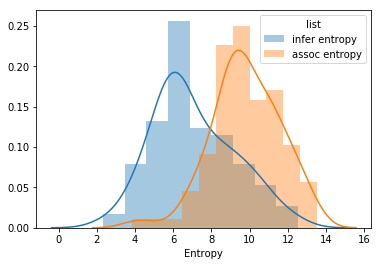

In [29]:
sns.distplot(df_entropy.infer)
sns.distplot(df_entropy.assoc)

plt.legend(title='list',loc='upper right', labels=['infer entropy', 'assoc entropy'])
plt.xlabel('Entropy')
plt.show()